In [1]:
# import pandas as pd

# # Đọc dữ liệu gốc
# data = pd.read_csv("data/paysim.csv")

# # Tách 10% dữ liệu để test real-time (có thể điều chỉnh tỉ lệ)
# test_real = data.sample(frac=0.1, random_state=42)
# train_data = data.drop(test_real.index)

# # Lưu lại hai file
# train_data.to_csv("data/paysim_train.csv", index=False)
# test_real.to_csv("data/paysim_realtime.csv", index=False)

# print("Train size:", train_data.shape)
# print("Realtime test size:", test_real.shape)


In [2]:
import pandas as pd

train_data = pd.read_csv("data/paysim_train.csv")
test_real = pd.read_csv("data/paysim_realtime.csv")

In [3]:
# Cell : EDA cơ bản (Train)
print("\nThông tin các cột:")
print(train_data.info())

print("\nThống kê mô tả các cột số:")
print(train_data.describe().T)

# Tỷ lệ gian lận (isFraud)
fraud_ratio = train_data['isFraud'].mean()
print(f"\nTỷ lệ gian lận: {fraud_ratio:.6f} ({fraud_ratio*100:.4f}%)")

# Đếm số lượng từng loại giao dịch
print("\nSố lượng mỗi loại giao dịch:")
print(train_data['type'].value_counts())



Thông tin các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726358 entries, 0 to 5726357
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 480.6+ MB
None

Thống kê mô tả các cột số:
                    count          mean           std  min       25%  \
step            5726358.0  2.433828e+02  1.423141e+02  1.0    156.00   
amount          5726358.0  1.797308e+05  6.027562e+05  0.0  13392.71   
oldbalanceOrg   5726358.0  8.344762e+05  2.889459e+06  0.0      0.00   
newbalanceOrig  5726358.0  8.556922e+05  2.925224e+06  0.0      0.00   
oldbalanceDest  5726358.0  1.1000

In [4]:
# Cell 2: EDA cơ bản (Test)
print("\nThông tin các cột:")
print(test_real.info())

print("\nThống kê mô tả các cột số:")
print(test_real.describe().T)

# Tỷ lệ gian lận (isFraud)
fraud_ratio = test_real['isFraud'].mean()
print(f"\nTỷ lệ gian lận: {fraud_ratio:.6f} ({fraud_ratio*100:.4f}%)")

# Đếm số lượng từng loại giao dịch
print("\nSố lượng mỗi loại giao dịch:")
print(test_real['type'].value_counts())



Thông tin các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            636262 non-null  int64  
 1   type            636262 non-null  object 
 2   amount          636262 non-null  float64
 3   nameOrig        636262 non-null  object 
 4   oldbalanceOrg   636262 non-null  float64
 5   newbalanceOrig  636262 non-null  float64
 6   nameDest        636262 non-null  object 
 7   oldbalanceDest  636262 non-null  float64
 8   newbalanceDest  636262 non-null  float64
 9   isFraud         636262 non-null  int64  
 10  isFlaggedFraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB
None

Thống kê mô tả các cột số:
                   count          mean           std  min       25%  \
step            636262.0  2.435273e+02  1.424932e+02  1.0    156.00   
amount          636262.0  1.81042

In [5]:
# Cell 3: Làm sạch dữ liệu cơ bản
df = train_data[train_data['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

# Mã hóa cột type thành số (0 hoặc 1)
df['type'] = df['type'].map({'CASH_OUT': 0, 'TRANSFER': 1}).astype('int8')

# Xóa các cột ID không hữu ích cho mô hình
df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)

print("Kích thước sau khi lọc:", df.shape)
df.head()


Kích thước sau khi lọc: (2493276, 8)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
1,1,1,181.00,181.00,0.0,0.0,0.00,1
2,1,0,181.00,181.00,0.0,21182.0,0.00,1
15,1,1,215310.30,705.00,0.0,22425.0,0.00,0
20,1,1,311685.89,10835.00,0.0,6267.0,2719172.89,0
42,1,0,56953.90,1942.02,0.0,70253.0,64106.18,0


In [6]:
# Cell 4: Feature engineering
import numpy as np

eps = 1e-9
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
df['amount_over_oldbalance'] = df['amount'] / (df['oldbalanceOrg'] + eps)
df['hour'] = (df['step'] % 24).astype('int8')
df['amount_log'] = np.log1p(df['amount'])

print("Các đặc trưng mới đã được tạo:")
print(df[['errorBalanceOrig','errorBalanceDest','amount_over_oldbalance','hour','amount_log']].head())


Các đặc trưng mới đã được tạo:
    errorBalanceOrig  errorBalanceDest  amount_over_oldbalance  hour  \
1               0.00            181.00                1.000000     1   
2               0.00          21363.00                1.000000     1   
15        -214605.30         237735.30              305.404681     1   
20        -300850.89       -2401220.00               28.766580     1   
42         -55011.88          63100.72               29.327144     1   

    amount_log  
1     5.204007  
2     5.204007  
15   12.279840  
20   12.649754  
42   10.950015  


In [7]:
# Cell 5: Chia train / test theo thời gian
cut_step = df['step'].quantile(0.7)  # 70% đầu làm train
train_df = df[df['step'] <= cut_step].reset_index(drop=True)
test_df  = df[df['step'] > cut_step].reset_index(drop=True)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)
print("Tỷ lệ fraud trong train:", train_df['isFraud'].mean())
print("Tỷ lệ fraud trong test:", test_df['isFraud'].mean())


Train size: (1756645, 13)
Test size: (736631, 13)
Tỷ lệ fraud trong train: 0.0018711805743334595
Tỷ lệ fraud trong test: 0.005578098125112845


In [8]:
# ! pip install matplotlib

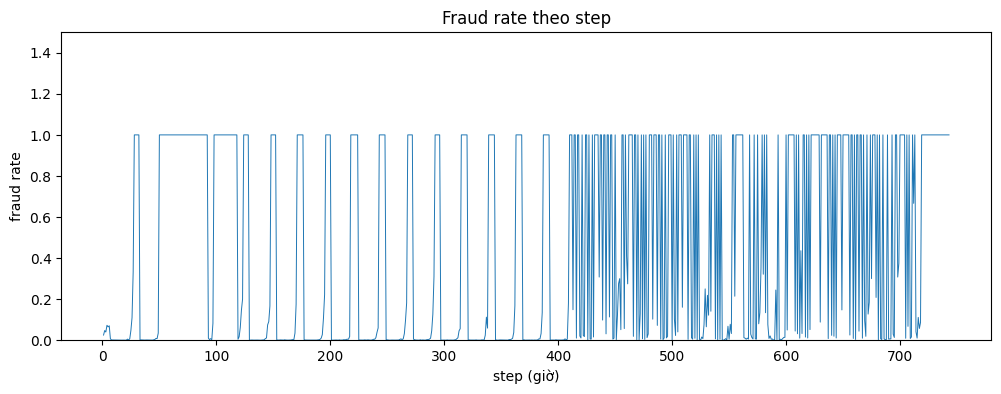

In [9]:
# Cell A: fraud rate theo step (hoặc theo nhóm step)
import matplotlib.pyplot as plt
import pandas as pd

# giả sử bạn có test_df và train_df như trước, hoặc df gốc
# nếu bạn chỉ có df, dùng df; ở đây dùng df chung:
temp = df.groupby('step')['isFraud'].mean().reset_index()   # trung bình = tỷ lệ fraud
plt.figure(figsize=(12,4))
plt.plot(temp['step'], temp['isFraud'], lw=0.7)
plt.xlabel('step (giờ)')
plt.ylabel('fraud rate')
plt.title('Fraud rate theo step')
plt.ylim(0, temp['isFraud'].max()*1.5)
plt.show()


In [10]:
# from sklearn.utils import resample

# train_fraud = train_df[train_df.isFraud==1]
# train_nonfraud = train_df[train_df.isFraud==0]

# train_nonfraud_down = resample(train_nonfraud,
#                                replace=False,
#                                n_samples=len(train_fraud)*200,  
#                                random_state=42)

# train_df_balanced = pd.concat([train_fraud, train_nonfraud_down])



In [11]:
# print("Train size:", train_df_balanced.shape)
# print("Test size:", test_df.shape)
# print("Tỷ lệ fraud trong train:", train_df_balanced['isFraud'].mean())
# print("Tỷ lệ fraud trong test:", test_df['isFraud'].mean())


In [12]:
# Cell 6: Chuẩn hóa dữ liệu số
from sklearn.preprocessing import StandardScaler

features = ['type', 'amount_log', 'errorBalanceOrig', 'errorBalanceDest', 'amount_over_oldbalance', 'hour']
X_train = train_df[features]
y_train = train_df['isFraud']
X_test  = test_df[features]
y_test  = test_df['isFraud']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
num_cols = [c for c in features if c != 'type']  # không scale cột type
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


In [13]:
import joblib

# Lưu scaler để dùng lại trong dự đoán realtime
joblib.dump(scaler, "scaler.pkl")
print(" scaler.pkl saved thành công.")

 scaler.pkl saved thành công.


In [14]:
# ! pip install xgboost

In [15]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': ['aucpr', 'auc'],
#     'eta': 0.03,
#     'max_depth': 5,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'scale_pos_weight': scale_pos_weight,
#     'lambda': 2.0,          # L2 regularization
#     'alpha': 0.5,           # L1 regularization
#     'tree_method': 'hist',  # nhanh hơn trên CPU
#     'verbosity': 1
# }

# evals = [(dtrain, 'train'), (dtest, 'test')]

# model = xgb.train(
#     params=params,
#     dtrain=dtrain,
#     num_boost_round=1000,
#     evals=evals,
#     early_stopping_rounds=100,
#     verbose_eval=50
# )
# model.save_model("xgb_model.json")

In [16]:
model = xgb.Booster()
model.load_model("xgb_model.json")

In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Tính xác suất dự đoán trên tập test
y_proba = model.predict(dtest)

best_threshold = 0.5
best_f1 = 0.0

print("Đang tìm ngưỡng tối ưu...\n")
for t in np.arange(0.1, 1, 0.05):  # thử từ 0.1 → 0.9 với bước 0.05
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Threshold={t:.2f} | Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\n✅ Ngưỡng tối ưu:")
print(f"Threshold = {best_threshold:.2f} (F1 = {best_f1:.3f})")


Đang tìm ngưỡng tối ưu...

Threshold=0.10 | Precision=0.051 | Recall=0.998 | F1=0.097
Threshold=0.15 | Precision=0.052 | Recall=0.998 | F1=0.099
Threshold=0.20 | Precision=0.053 | Recall=0.997 | F1=0.100
Threshold=0.25 | Precision=0.054 | Recall=0.996 | F1=0.103
Threshold=0.30 | Precision=0.057 | Recall=0.995 | F1=0.107
Threshold=0.35 | Precision=0.062 | Recall=0.991 | F1=0.117
Threshold=0.40 | Precision=0.073 | Recall=0.981 | F1=0.136
Threshold=0.45 | Precision=0.081 | Recall=0.976 | F1=0.149
Threshold=0.50 | Precision=0.091 | Recall=0.968 | F1=0.167
Threshold=0.55 | Precision=0.119 | Recall=0.951 | F1=0.212
Threshold=0.60 | Precision=0.154 | Recall=0.931 | F1=0.264
Threshold=0.65 | Precision=0.192 | Recall=0.919 | F1=0.318
Threshold=0.70 | Precision=0.255 | Recall=0.904 | F1=0.397
Threshold=0.75 | Precision=0.357 | Recall=0.892 | F1=0.510
Threshold=0.80 | Precision=0.442 | Recall=0.881 | F1=0.589
Threshold=0.85 | Precision=0.534 | Recall=0.872 | F1=0.662
Threshold=0.90 | Precision=0.

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


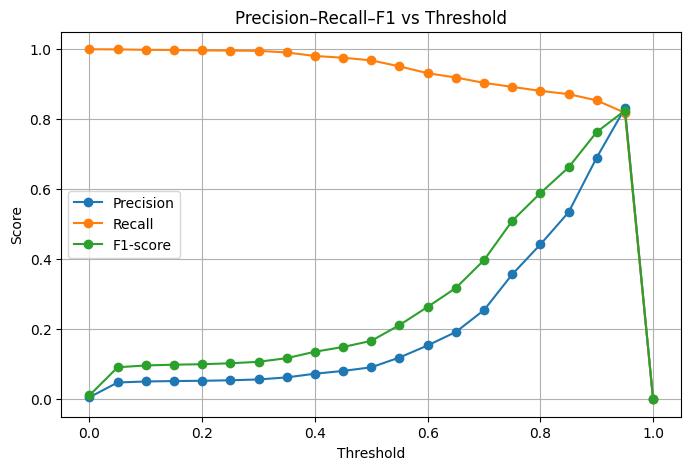

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1-score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall–F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Cell 8: Đánh giá mô hình
y_proba = model.predict(dtest)
y_pred = (y_proba >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.9951540334969952
PR-AUC: 0.8721993603083308

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    732522
           1       0.09      0.97      0.17      4109

    accuracy                           0.95    736631
   macro avg       0.55      0.96      0.57    736631
weighted avg       0.99      0.95      0.97    736631

Confusion matrix:
 [[692910  39612]
 [   131   3978]]


In [20]:
# ! pip install seaborn

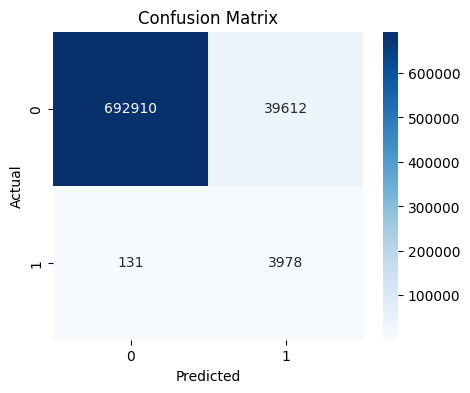

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_proba = (y_pred > 0.9).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


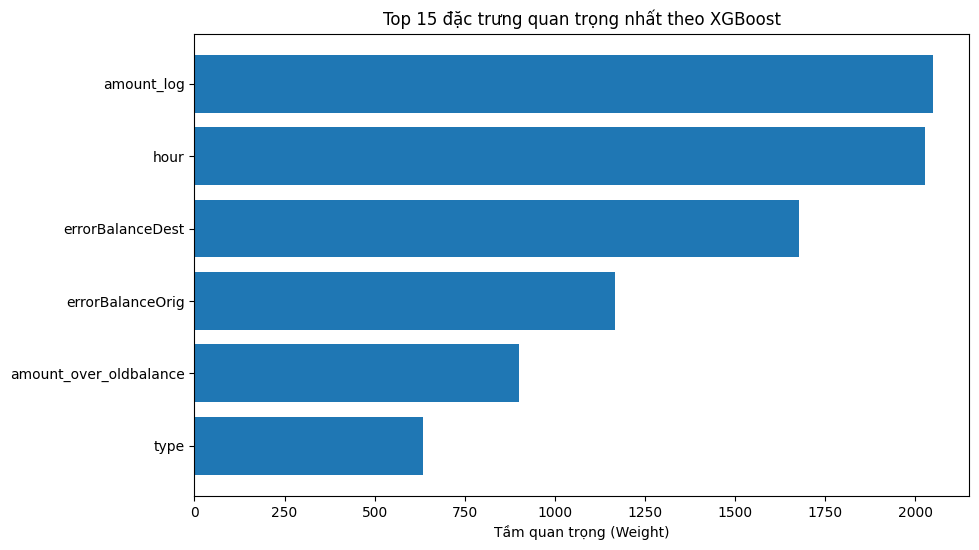

In [22]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Lấy tầm quan trọng đặc trưng từ mô hình
importance = model.get_score(importance_type='weight')

# Chuyển sang DataFrame cho dễ vẽ
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Tầm quan trọng (Weight)")
plt.title("Top 15 đặc trưng quan trọng nhất theo XGBoost")
plt.show()


In [23]:
 # ! pip install shap



In [24]:
# # Cell: SHAP via shap.Explainer(model_callable)
# import shap
# shap.initjs()

# # sample to speed up
# n_sample = min(5000, X_test_scaled.shape[0])
# X_shap_sample = X_test_scaled.sample(n_sample, random_state=42)

# # define a callable that takes a 2D numpy/pandas array and returns model output probabilities
# def model_predict_proba(X):
#     # X can be a pandas DataFrame or numpy array
#     dmat = xgb.DMatrix(X, feature_names=list(X.columns))
#     return model.predict(dmat)  # returns probability for class 1

# explainer = shap.Explainer(model_predict_proba, X_shap_sample)   # black-box explainer
# shap_values = explainer(X_shap_sample)

# # summary bar plot (works with new API)
# shap.plots.bar(shap_values, max_display=20)


In [25]:
# # ! pip install fastapi uvicorn pydantic
# ! pip install redis

In [26]:
# ! pip install kafka-python


In [27]:
import redis
import xgboost as xgb
import pandas as pd
import numpy as np
import joblib

# 🔹 Load scaler & model
scaler = joblib.load("scaler.pkl")
model = xgb.Booster()
model.load_model("xgb_model.json")

# 🔹 Kết nối Redis
r = redis.Redis(host='redis', port=6379, db=0, decode_responses=True)

# 🔹 Danh sách đặc trưng đúng với mô hình
FEATURES = ["type", "amount_log", "errorBalanceOrig", "errorBalanceDest", "amount_over_oldbalance", "hour"]
NUM_COLS = ["amount_log", "errorBalanceOrig", "errorBalanceDest", "amount_over_oldbalance", "hour"]

def predict_transaction(tx):
    """Dự đoán 1 giao dịch realtime"""
    
    # Chỉ xử lý 2 loại bạn đã train
    type_mapping = {'CASH_OUT': 0, 'TRANSFER': 1}
    tx_type = tx.get("type", "")
    if tx_type not in type_mapping:
        return None, {"message": f"⏭️ Bỏ qua giao dịch loại '{tx_type}' (không thuộc TRANSFER/CASH_OUT)"}

    # 1️⃣ Feature engineering
    df = pd.DataFrame([{
        "type": type_mapping[tx_type],
        "amount_log": np.log1p(tx["amount"]),
        "errorBalanceOrig": tx["oldbalanceOrg"] - tx["newbalanceOrig"] - tx["amount"],
        "errorBalanceDest": tx["oldbalanceDest"] + tx["amount"] - tx["newbalanceDest"],
        "amount_over_oldbalance": tx["amount"] / (tx["oldbalanceOrg"] + 1e-9),
        "hour": tx["step"] % 24
    }])

    df['type'] = df['type'].astype('int8')
    df['hour'] = df['hour'].astype('int8')

    # 2️⃣ Chuẩn hóa dữ liệu số
    df_scaled = df.copy()
    df_scaled[NUM_COLS] = scaler.transform(df[NUM_COLS])

    # 3️⃣ Dự đoán với XGBoost
    dmatrix = xgb.DMatrix(df_scaled, feature_names=FEATURES)
    pred_prob = model.predict(dmatrix)
    is_fraud = int(pred_prob[0] > 0.9)

    # 4️⃣ Cập nhật Redis counters
    key = 'fraud' if is_fraud else 'nonfraud'
    r.incr(key)
    counters = {'fraud': r.get('fraud') or 0, 'nonfraud': r.get('nonfraud') or 0}

    return is_fraud, counters



In [28]:
# r.flushdb()
# # reset redis

In [29]:
import pandas as pd

# Đọc dữ liệu realtime (gồm cả nhãn thật)
realtime_data = pd.read_csv("data/paysim_realtime.csv")

# Reset Redis counters
r.delete('fraud', 'nonfraud')

fraud_detected = 0
correct_preds = 0
wrong_preds = 0
total_tx = len(realtime_data)

print(f"🔍 Bắt đầu kiểm tra {total_tx:,} giao dịch realtime...\n")

for i, row in enumerate(realtime_data.itertuples(index=False), start=1):
    tx = row._asdict()
    is_fraud, counters = predict_transaction(tx)
    true_label = tx.get("isFraud", 0)

    if is_fraud == 1:
        fraud_detected += 1
        if true_label == 1:
            correct_preds += 1
            correctness = "✅ ĐÚNG"
        else:
            wrong_preds += 1
            correctness = "❌ SAI"
        
        print(f"⚠️  Giao dịch nghi gian lận #{fraud_detected}: "
              f"ID={tx.get('nameOrig', 'N/A')} | amount={tx.get('amount')} | step={tx.get('step')} | "
              f"Thực tế: {true_label} ({correctness})")




🔍 Bắt đầu kiểm tra 636,262 giao dịch realtime...

⚠️  Giao dịch nghi gian lận #1: ID=C747251675 | amount=806863.3 | step=294 | Thực tế: 1 (✅ ĐÚNG)
⚠️  Giao dịch nghi gian lận #2: ID=C555990868 | amount=1170282.92 | step=51 | Thực tế: 1 (✅ ĐÚNG)
⚠️  Giao dịch nghi gian lận #3: ID=C728404974 | amount=73121.53 | step=311 | Thực tế: 0 (❌ SAI)
⚠️  Giao dịch nghi gian lận #4: ID=C1724151856 | amount=1159010.44 | step=133 | Thực tế: 1 (✅ ĐÚNG)
⚠️  Giao dịch nghi gian lận #5: ID=C1597532939 | amount=149376.8 | step=169 | Thực tế: 0 (❌ SAI)
⚠️  Giao dịch nghi gian lận #6: ID=C1034067842 | amount=953615.38 | step=689 | Thực tế: 1 (✅ ĐÚNG)
⚠️  Giao dịch nghi gian lận #7: ID=C1711836423 | amount=334890.91 | step=223 | Thực tế: 1 (✅ ĐÚNG)
⚠️  Giao dịch nghi gian lận #8: ID=C1743024374 | amount=521385.54 | step=132 | Thực tế: 0 (❌ SAI)
⚠️  Giao dịch nghi gian lận #9: ID=C1873382948 | amount=636942.02 | step=467 | Thực tế: 1 (✅ ĐÚNG)
⚠️  Giao dịch nghi gian lận #10: ID=C1129518026 | amount=2060748.45

In [32]:
print(f"🔹 Tổng giao dịch: {total_tx}")
print(f"🔹 Mô hình dự đoán gian lận: {fraud_detected}")
print(f"   ├─ Đúng (trùng nhãn thật): {correct_preds}")
print(f"   └─ Sai (báo nhầm): {wrong_preds}")
fraud_rows = realtime_data[realtime_data["isFraud"] == 1]
print("Số giao dịch gian lận thực tế:", len(fraud_rows))

accuracy = correct_preds / len(fraud_rows) * 100
print(f"Độ chính xác gian lận dự báo: {accuracy:.2f}%") 


🔹 Tổng giao dịch: 636262
🔹 Mô hình dự đoán gian lận: 1349
   ├─ Đúng (trùng nhãn thật): 693
   └─ Sai (báo nhầm): 656
Số giao dịch gian lận thực tế: 817
Độ chính xác gian lận dự báo: 84.82%


In [36]:
print(f"🔹 Tổng giao dịch: {total_tx}")
print(f"🔹 Mô hình dự đoán gian lận: {fraud_detected}")
print(f"   ├─ Đúng (trùng nhãn thật): {correct_preds}")
print(f"   └─ Sai (báo nhầm): {wrong_preds}")
fraud_rows = realtime_data[realtime_data["isFraud"] == 1]
print("Số giao dịch gian lận thực tế:", len(fraud_rows))

accuracy = correct_preds / len(fraud_rows) * 100
print(f"Độ chính xác gian lận dự báo: {accuracy:.2f}%") 


🔹 Tổng giao dịch: 636262
🔹 Mô hình dự đoán gian lận: 15741
   ├─ Đúng (trùng nhãn thật): 786
   └─ Sai (báo nhầm): 14955
Số giao dịch gian lận thực tế: 817
Độ chính xác gian lận dự báo: 96.21%
